In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from classifier import *
torch.cuda.is_available(), torch.backends.cudnn.enabled

/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(True, True)

In [2]:
PATH = Path('/home/sean/hpc-home/skin_cancer/')
test_folder = 'ISIC/ISIC-2017_Test_v2_Data_Classification/'
test_csv = PATH / 'ISIC/test_isic17.csv'

test_mel_p = PATH / 'ISIC/test_mel_17.csv'
test_ker_p = PATH / 'ISIC/test_ker_17.csv'
test_all_p = PATH / 'ISIC/test_all_17.csv'
test_raw_p = PATH / 'ISIC/test_raw_17.csv'

train_skp = PATH / 'train_multi_sk.csv'
train_melp = PATH / 'train_multi_mel.csv'
train_all = PATH / 'train_multi.csv'
train_raw = PATH / 'train_multi_raw.csv'

%ls $PATH

dermofit/             ph2dataset/                      train_multi_mel.csv*
ISIC/                 test_isic17_dermofitLabels.csv*  train_multi_raw.csv*
isic18_p3_test_data*  tmp/                             train_multi_sk.csv*
isic_archive/         train_dermofit_isic17.csv*       val_isic17.csv*
models/               train_multi.csv*


In [ ]:
def add_class_col(df, cats=['melanoma', 'keratosis']):
    df['class'] = np.nan
    for c in cats:
        print('adding %s to class' % c)
        df['class'].iloc[df[c].nonzero()[0]] = c
    df['class'].fillna('nevus', inplace=True)
    df.head()
    return df

In [5]:
dep = PATH / 'isic_archive/recod_titans_sub/data/deploy2017.txt'
rec = pd.read_csv(dep)
rec.columns = [ss.strip() for ss in rec.columns]
rec = rec.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
rec.head()

,image,case,type,age,has_age,sex,has_sex,melanoma,keratosis,schedule,weight,dataset
0,adl379,4A378379,d,45,1,female,1,0,0,2,3,atlas
1,ael455,4A454455,d,57,1,male,1,0,0,2,3,atlas
2,ael469,4A468469,d,68,1,female,1,0,0,1,3,atlas
3,ael502,4A501502,d,40,1,female,1,0,0,2,3,atlas
4,ael505,4A505505,d,65,1,male,1,0,0,2,3,atlas


In [8]:
rec['dataset'].value_counts()

isic         4045
challenge    2000
atlas        1988
dermofit     1300
irma          187
ph2           120
Name: dataset, dtype: int64

In [3]:
test_df = pd.read_csv(test_csv)
test_df['classes'].value_counts()

nevus                   393
melanoma                117
seborrheic_keratosis     90
Name: classes, dtype: int64

In [4]:
test_df['melanoma'] = (test_df['classes'] == 'melanoma').astype(int)
test_df['keratosis'] = (test_df['classes'] == 'keratosis').astype(int)
test_df.index = 'ISIC/ISIC-2017_Test_v2_Data/' + test_df['image_id'] + '.jpg'
test_df.drop(columns=['image_id'], inplace=True)
test_df.head()

,classes,melanoma,keratosis
image_id,,,
ISIC/ISIC-2017_Test_v2_Data/ISIC_0012086.jpg,seborrheic_keratosis,0,0
ISIC/ISIC-2017_Test_v2_Data/ISIC_0012092.jpg,nevus,0,0
ISIC/ISIC-2017_Test_v2_Data/ISIC_0012095.jpg,nevus,0,0
ISIC/ISIC-2017_Test_v2_Data/ISIC_0012134.jpg,seborrheic_keratosis,0,0
ISIC/ISIC-2017_Test_v2_Data/ISIC_0012136.jpg,seborrheic_keratosis,0,0


In [126]:
test_df.to_csv(test_raw_p)
test_df_mel = test_df.drop(columns=['classes', 'keratosis'])
test_df_ker = test_df.drop(columns=['classes', 'melanoma'])
test_df_all = test_df.drop(columns=['keratosis', 'melanoma'])

test_df_mel.to_csv(test_mel_p)
test_df_ker.to_csv(test_ker_p)
test_df_all.to_csv(test_all_p)

nevus                   393
melanoma                117
seborrheic_keratosis     90
Name: classes, dtype: int64

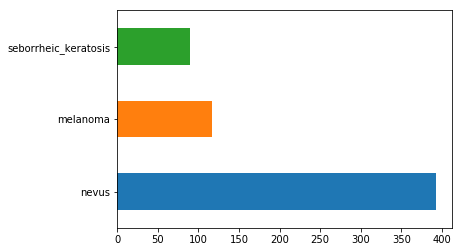

In [141]:
test_df['classes'].value_counts().plot(kind='barh')
test_df['classes'].value_counts()

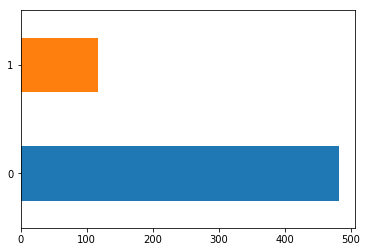

In [124]:
test_df_mel['melanoma'].value_counts().plot(kind='barh')

### Isic Archive data labels

In [6]:
def getds(data): return rec.loc[rec['dataset'] == data][['image', 'melanoma', 'keratosis']]
ia = getds('isic')
ia = ia[['melanoma', 'keratosis']].set_index('isic_archive/images/' + ia['image'] + '.jpg')
ia.head()

,melanoma,keratosis
image,,
isic_archive/images/5436e3acbae478396759f0e5.jpg,0,0
isic_archive/images/5593f47b9fc3c131551460fc.jpg,0,0
isic_archive/images/5436e3f4bae478396759f4a6.jpg,0,0
isic_archive/images/558d637cbae47801cf734dbc.jpg,1,0
isic_archive/images/558d60e8bae47801cf7345b2.jpg,1,0


In [16]:
iap = PATH / 'isic_archive/images'
ims = [iap / i for i in iap.glob('*.jpg')]

In [18]:
# for i in ims:
#     bn = i.with_suffix('').name
#     if bn not in ia['image'].tolist():
#         print(f'image not in labels - "{bn}"')

### PH2 Data Labels

In [19]:
pdf = getds('ph2')
pdf.head()

,image,melanoma,keratosis
8220,IMD003,0,0
8221,IMD009,0,0
8222,IMD016,0,0
8223,IMD022,0,0
8224,IMD024,0,0


In [20]:
pims = pdf['image'].tolist()
pims = ['ph2dataset/PH2_Dataset_images/'+i+f'/{i}_Dermoscopic_Image/{i}.bmp' for i in pims]
all([(PATH / ss).exists() for ss in pims])

True

In [21]:
pdf.index = pims
pdf = pdf[['melanoma', 'keratosis']]
pdf.head()

,melanoma,keratosis
ph2dataset/PH2_Dataset_images/IMD003/IMD003_Dermoscopic_Image/IMD003.bmp,0,0
ph2dataset/PH2_Dataset_images/IMD009/IMD009_Dermoscopic_Image/IMD009.bmp,0,0
ph2dataset/PH2_Dataset_images/IMD016/IMD016_Dermoscopic_Image/IMD016.bmp,0,0
ph2dataset/PH2_Dataset_images/IMD022/IMD022_Dermoscopic_Image/IMD022.bmp,0,0
ph2dataset/PH2_Dataset_images/IMD024/IMD024_Dermoscopic_Image/IMD024.bmp,0,0


### Dermofit Data Labels

In [22]:
ddf = getds('dermofit')
ddf.head()

,image,melanoma,keratosis
8340,D204a,0,0
8341,D222,0,0
8342,D226b,0,0
8343,D226c,0,0
8344,D227,0,0


To get the paths.

1 Could get all the image paths with os.walk and match to the image id in the DF. 

2 Could lookup the image id in a dermofit text file to find it. 

3 Generate the labels myself for Mel vs Ker?

In [23]:
ddf_t = pd.read_csv(PATH / 'dermofit/train.csv')
ddf_t.columns = ['image', 'class']
ddf_t.head()

,image,class
0,ALLBCC/D204a/D204a,BCC
1,ALLSCC/D222/D222,SCC
2,ALLML/D226b/D226b,ML
3,ALLML/D226c/D226c,ML
4,ALLML/D227/D227,ML


In [24]:
ddf_ids = ddf['image'].tolist()
ddf_pths = ddf_t['image'].tolist()
[os.path.basename(ss) for ss in ddf_pths] == ddf_ids

True

In [25]:
dermfit_image_id = ['dermofit/' + i + '.png' for i in ddf_pths]
all([(PATH / i).exists() for i in dermfit_image_id])

True

In [26]:
ddf = ddf[['melanoma', 'keratosis']]
ddf.index = dermfit_image_id
ddf.head()

,melanoma,keratosis
dermofit/ALLBCC/D204a/D204a.png,0,0
dermofit/ALLSCC/D222/D222.png,0,0
dermofit/ALLML/D226b/D226b.png,0,0
dermofit/ALLML/D226c/D226c.png,0,0
dermofit/ALLML/D227/D227.png,0,0


### ISIC 2017 Training Data

In [28]:
ict = getds('challenge')
ict.index = 'ISIC/ISIC-2017_Training_Data/' + ict['image'] + '.jpg'
ict = ict[['melanoma', 'keratosis']]
ict.head()

,melanoma,keratosis
image,,
ISIC/ISIC-2017_Training_Data/ISIC_0000000.jpg,0,0
ISIC/ISIC-2017_Training_Data/ISIC_0000001.jpg,0,0
ISIC/ISIC-2017_Training_Data/ISIC_0000002.jpg,1,0
ISIC/ISIC-2017_Training_Data/ISIC_0000003.jpg,0,0
ISIC/ISIC-2017_Training_Data/ISIC_0000004.jpg,1,0


### ISIC 2017 Validation Data

In [29]:
icv = pd.read_csv(PATH / 'val_isic17.csv')
icv.columns = ['image', 'class']

icv['melanoma'] = (icv['class'] == 'MEL').astype(int)
icv['keratosis'] = (icv['class'] == 'SK').astype(int)
icv.set_index(icv['image'], inplace=True)

icv.drop(columns=['class', 'image'], inplace=True)
icv.head()

,melanoma,keratosis
image,,
ISIC/ISIC-2017_Validation_Data/ISIC_0001769.jpg,0,0
ISIC/ISIC-2017_Validation_Data/ISIC_0001852.jpg,0,0
ISIC/ISIC-2017_Validation_Data/ISIC_0001871.jpg,0,0
ISIC/ISIC-2017_Validation_Data/ISIC_0003462.jpg,0,0
ISIC/ISIC-2017_Validation_Data/ISIC_0003539.jpg,0,0


In [30]:
len(icv)

150

### Combine all DFs and get Idx for validation set

In [128]:
train_df = pd.concat([ia, pdf, ddf, icv])
train_df.head()
# len(train_csv)

,melanoma,keratosis
isic_archive/images/5436e3acbae478396759f0e5.jpg,0,0
isic_archive/images/5593f47b9fc3c131551460fc.jpg,0,0
isic_archive/images/5436e3f4bae478396759f4a6.jpg,0,0
isic_archive/images/558d637cbae47801cf734dbc.jpg,1,0
isic_archive/images/558d60e8bae47801cf7345b2.jpg,1,0


In [129]:
len(train_df)

5615

In [130]:
train_df.iloc[-150:]

,melanoma,keratosis
ISIC/ISIC-2017_Validation_Data/ISIC_0001769.jpg,0,0
ISIC/ISIC-2017_Validation_Data/ISIC_0001852.jpg,0,0
ISIC/ISIC-2017_Validation_Data/ISIC_0001871.jpg,0,0
ISIC/ISIC-2017_Validation_Data/ISIC_0003462.jpg,0,0
ISIC/ISIC-2017_Validation_Data/ISIC_0003539.jpg,0,0
ISIC/ISIC-2017_Validation_Data/ISIC_0003582.jpg,0,0
ISIC/ISIC-2017_Validation_Data/ISIC_0003657.jpg,0,0
ISIC/ISIC-2017_Validation_Data/ISIC_0003805.jpg,0,0
ISIC/ISIC-2017_Validation_Data/ISIC_0004337.jpg,0,0
ISIC/ISIC-2017_Validation_Data/ISIC_0006651.jpg,0,0


In [131]:
val_idx = list(range(len(train_df) - 150, len(train_df)))
# len(train_df) = 5615
len(train_df)

5615

In [ ]:
train_df.iloc(:-150)

0    4768
1     847
Name: melanoma, dtype: int64

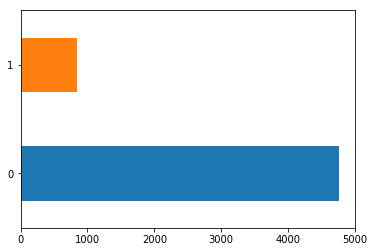

In [132]:
train_df['melanoma'].value_counts().plot(kind='barh')
train_df['melanoma'].value_counts()

0    5307
1     308
Name: keratosis, dtype: int64

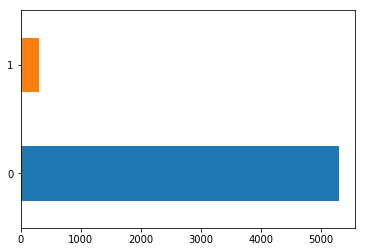

In [134]:
train_df['keratosis'].value_counts().plot(kind='barh')
train_df['keratosis'].value_counts()

In [133]:
train_df.head()

,melanoma,keratosis
isic_archive/images/5436e3acbae478396759f0e5.jpg,0,0
isic_archive/images/5593f47b9fc3c131551460fc.jpg,0,0
isic_archive/images/5436e3f4bae478396759f4a6.jpg,0,0
isic_archive/images/558d637cbae47801cf734dbc.jpg,1,0
isic_archive/images/558d60e8bae47801cf7345b2.jpg,1,0


In [135]:
cats = ['melanoma', 'keratosis']
# train_df[cats]
# nonzero_indexs = train_df['melanoma'].apply(np.nonzero)
# nonzero_indexs[1]
# train_df['melanoma'].nonzero()[0]

In [81]:
train_df['melanoma'].iloc[1:5]

isic_archive/images/5593f47b9fc3c131551460fc.jpg    0
isic_archive/images/5436e3f4bae478396759f4a6.jpg    0
isic_archive/images/558d637cbae47801cf734dbc.jpg    1
isic_archive/images/558d60e8bae47801cf7345b2.jpg    1
Name: melanoma, dtype: int64

In [136]:
train_df['class'] = np.nan
for c in cats:
    print('adding %s to class' % c)
    train_df['class'].iloc[train_df[c].nonzero()[0]] = c
train_df['class'].fillna('nevus', inplace=True)
train_df.head()

adding melanoma to class
adding keratosis to class


/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,melanoma,keratosis,class
isic_archive/images/5436e3acbae478396759f0e5.jpg,0,0,nevus
isic_archive/images/5593f47b9fc3c131551460fc.jpg,0,0,nevus
isic_archive/images/5436e3f4bae478396759f4a6.jpg,0,0,nevus
isic_archive/images/558d637cbae47801cf734dbc.jpg,1,0,melanoma
isic_archive/images/558d60e8bae47801cf7345b2.jpg,1,0,melanoma


In [137]:
# train_df.drop(columns='classes', inplace=True)
train_df.head()

,melanoma,keratosis,class
isic_archive/images/5436e3acbae478396759f0e5.jpg,0,0,nevus
isic_archive/images/5593f47b9fc3c131551460fc.jpg,0,0,nevus
isic_archive/images/5436e3f4bae478396759f4a6.jpg,0,0,nevus
isic_archive/images/558d637cbae47801cf734dbc.jpg,1,0,melanoma
isic_archive/images/558d60e8bae47801cf7345b2.jpg,1,0,melanoma


In [139]:
train_df.to_csv(train_raw)

train_df.drop(columns=['keratosis', 'melanoma']).to_csv(train_all)

train_mel = train_df.drop(columns=['keratosis', 'class'])
train_mel.to_csv(train_melp)

train_sk = train_df.drop(columns=['melanoma', 'class'])
train_sk.to_csv(train_skp)

nevus        4460
melanoma      847
keratosis     308
Name: class, dtype: int64

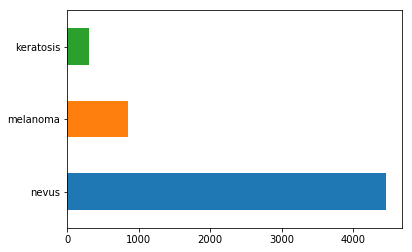

In [140]:
train_df['class'].value_counts().plot(kind='barh')
train_df['class'].value_counts()

## Load Data and Train

In [107]:
# The network architecture to use, resnet34 is a good start, will get better performance with resnext50 or inceptionv4
arch=resnet34
# image size
sz=224
bs=64

# Dataset augmentations
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down)
# The dataloader, used for training and evaluation, has numerous useful functions for:
# loading data, preprocessing, batching, obtaining basic stats, and more
data = ImageClassifierData.from_csv(PATH, '', train_all, tfms=tfms,
                    suffix='', bs=bs, test_name=test_folder, val_idxs=val_idx)

In [108]:
data.classes

['Nevus_or_Other', 'keratosis', 'melanoma']

Dataset has: ['Nevus_or_Other', 'keratosis', 'melanoma'] classes


 85%|████████▍ | 73/86 [00:05<00:01, 12.68it/s, loss=1.32]


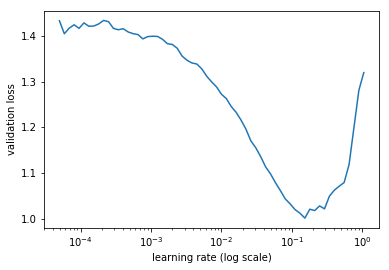

In [113]:
tr = trainer(data, arch, sn='toy_train_3cls')
tr.lr_find()

In [114]:
tr.set_lr(5e-2)
tr.init_train()

epoch      trn_loss   val_loss   accuracy                  
    0      0.635019   1.760249   0.566667  
    1      0.531201   2.340154   0.533333                  
    2      0.464564   1.519413   0.553333                  
    3      0.41874    1.603589   0.526667                  



epoch      trn_loss   val_loss   accuracy                  
    0      0.367917   1.615076   0.573333  
    1      0.335529   1.569482   0.58                      
    2      0.329267   1.510798   0.566667                  

Saved weights as "toy_train_3cls"


In [192]:
# for i in range(min(len(data.classes),10)): sample_ims(PATH, i, data)

## Setup and Train Network

In [193]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 10/10 [02:00<00:00, 12.04s/it]


 85%|████████▍ | 73/86 [00:06<00:01, 11.18it/s, loss=1.03] 


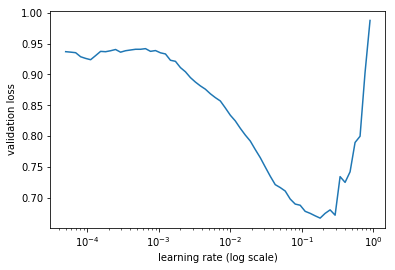

In [194]:
lrf=learn.lr_find()
learn.sched.plot()

In [195]:
learn.fit(1e-1, 4)

epoch      trn_loss   val_loss   accuracy                  
    0      0.645109   1.153685   0.706667  
    1      0.448732   0.486336   0.773333                  
    2      0.347546   0.462144   0.8                       
    3      0.288915   0.457796   0.826667                  



[array([0.4578]), 0.8266666634877523]

In [196]:
learn.fit(1e-1, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.255034   0.448638   0.833333  
    1      0.241961   0.466086   0.813333                  
    2      0.249191   0.47212    0.82                      



[array([0.47212]), 0.8200000007947286]

In [197]:
learn.save('224_multi_part3_1')

 93%|█████████▎| 80/86 [02:50<00:12,  2.13s/it, loss=0.634]

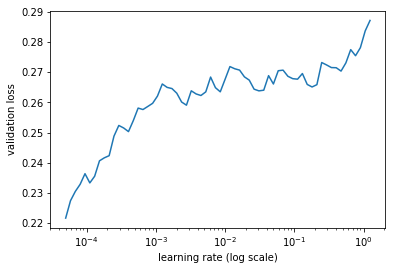

In [200]:
learn.precompute = False
lrf=learn.lr_find()
learn.sched.plot()

In [201]:
learn.fit(1e-2, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.269895   0.482738   0.813333  
    1      0.257247   0.467752   0.82                      
    2      0.252182   0.473153   0.813333                  


[array([0.47315]), 0.813333334128062]

In [202]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 5, cycle_len=3)

epoch      trn_loss   val_loss   accuracy                  
    0      0.320758   0.414514   0.826667  
    1      0.276458   0.408954   0.84                      
    2      0.265311   0.418435   0.82                      
    3      0.256885   0.414706   0.833333                  
    4      0.257364   0.409248   0.833333                  
    5      0.241426   0.411671   0.846667                  
    6      0.243927   0.409673   0.846667                  
    7      0.229314   0.416766   0.826667                  
    8      0.219436   0.410767   0.84                      
    9      0.221191   0.411044   0.82                      
    10     0.213018   0.404931   0.833333                  
    11     0.203224   0.410033   0.833333                  
    12     0.204563   0.413692   0.84                      
    13     0.201655   0.405102   0.82                      
 40%|███▉      | 34/86 [01:22<02:06,  2.43s/it, loss=0.197]

KeyboardInterrupt: 

## Evaluation

Accuracy = 0.85                              
Confusion Matrix:
[[117   3]
 [ 20  10]]
AUC for class 0, id 0 = 0.82
AUC for class 1, id 1 = 0.82
----------------------------------------
[[117   3]
 [ 20  10]]


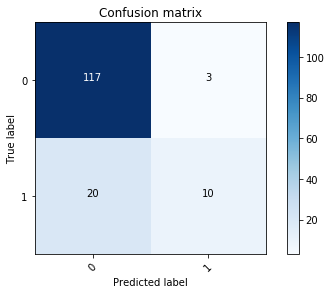

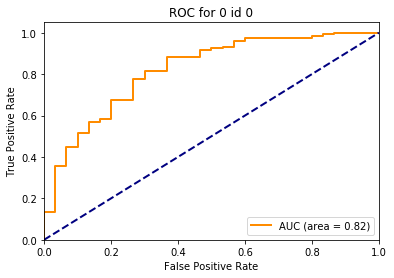

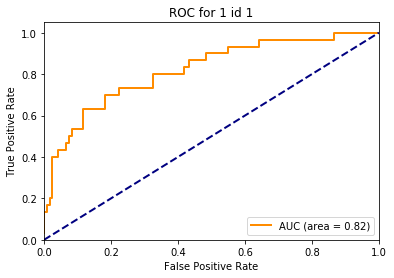

In [203]:
vf_preds, vy, vacc, vcm, vroc_auc, vfpr, vtpr = run_test(learn, sf=True)

Loading ys from csv; shape (600,); vals [0 1]
Accuracy = 0.72
Confusion Matrix:
[[419  64]
 [104  13]]
AUC for class 0, id 0 = 0.51
AUC for class 1, id 1 = 0.51
----------------------------------------
[[419  64]
 [104  13]]


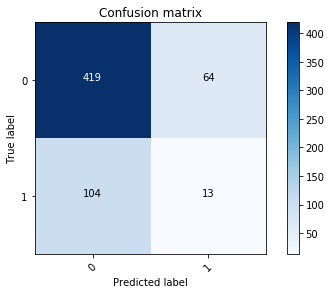

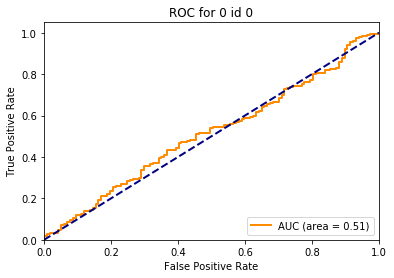

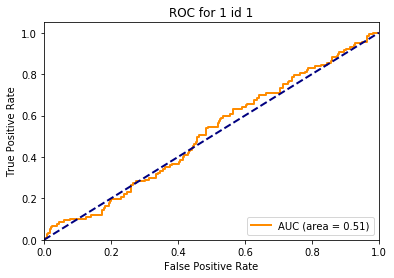

In [229]:
vf_preds, vy, vacc, vcm, vroc_auc, vfpr, vtpr = run_test(learn, ts=True, sf=True, test_csv=t_mel_p)

In [231]:
arch.__name__

'resnet34'